In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
import scipy
import torch.nn.functional as F
import copy
from torch import nn
from torch import optim
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import ChebConv
from torch.nn import Module, Parameter

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Variational Graph AutoEncoder

In [3]:
def sparse_degree_matrix(A) -> torch.sparse.FloatTensor:
    D = scipy.sparse.spdiags(torch.sparse.sum(A, dim=1).to_dense(),0, *A.shape).tocoo()
    return coo_to_torch_sparse_matrix(D)

In [4]:
def coo_to_torch_sparse_matrix(coo):
    idx = torch.LongTensor(coo.nonzero())
    data = torch.FloatTensor(coo.data)
    return torch.sparse.FloatTensor(idx, data)

In [5]:
def laplacian(A, normalized=True):
    I = torch.eye(A.shape[0])
    D = sparse_degree_matrix(A)
    if not normalized:
        L = D.sub(A)
    else:
        D = (D**(-0.5)).to_dense()
        p1 = torch.spmm(A, D)
        L = torch.mm(p1, D)
        # L = coo_to_torch_sparse_matrix(scipy.sparse.coo_matrix(I - p2))

    return L

In [6]:
def get_acc(adj_rec, adj_label):
    labels_all = adj_label.view(-1).long()
    preds_all = (adj_rec > 0.5).view(-1).long()
    accuracy = (preds_all == labels_all).sum().float() / labels_all.size(0)
    return accuracy

In [7]:
M_test = torch.sparse.FloatTensor(data.edge_index, torch.FloatTensor(np.repeat(1, len(data.edge_index[1]))))
# L = laplacian(M_test)
L = M_test.to_dense().double()

In [8]:
class GraphConvolutionLayer(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """
    def __init__(self, in_features, out_features):
        super(GraphConvolutionLayer, self).__init__()
        init_range = np.sqrt(6.0/(in_features + out_features)) # Glorot initialization
        self.weight = Parameter(torch.rand(in_features, out_features, dtype=torch.double) * 2 * init_range - init_range)
        self.bias = Parameter(torch.DoubleTensor(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        return output # + self.bias

In [9]:
class VGAE(Module):
    def __init__(self, nfeat, nhid, dimz, n_samples):
        super(VGAE, self).__init__()
        self.n_samples = n_samples
        self.nhid = nhid
        self.gc1 = GraphConvolutionLayer(nfeat, nhid)
        self.gc2mu = GraphConvolutionLayer(nhid, dimz)
        self.gc2std = GraphConvolutionLayer(nhid, dimz)
        
    def encode(self, x, adj):
        # First GCN
        x = F.relu(self.gc1(x, adj))
        # Mean and std
        self.mean = self.gc2mu(x, adj)
        self.log_std = self.gc2std(x, adj)
        # Latent representation
        return self.mean + torch.mul(self.log_std, torch.randn_like(self.log_std))
        
    def decode(self, z):
        return torch.sigmoid(torch.matmul(z, z.t()))
        
    def forward(self, x, adj):
        z = self.encode(x, adj)
        A_recon = self.decode(z)
        return A_recon
    
    def loss(self, A_hat, A, norm, weight_tensor):
        # Binary Crossentropy loss
        # bce_loss = nn.BCELoss(reduce='sum')(A_hat, A)
        bce_loss = norm * F.binary_cross_entropy(A_hat.view(-1), A.view(-1), weight = weight_tensor)
        # KL Loss
        kl_loss = - 0.5 * torch.mean(torch.sum(1 + self.log_std - self.mean.pow(2) - self.log_std.exp(), dim=1)) 
        # kl_loss = 0.5/ A_hat.shape[0] * (1 + 2*self.log_std - self.mean.pow(2) - self.log_std.exp()).sum(1).mean()
        return bce_loss + kl_loss
        

In [10]:
vgae = VGAE(1433, 32, 16, data.x.shape[0])
optimizer = optim.Adam(vgae.parameters(), lr=0.01)

pos_weight = float(L.shape[0] * L.shape[0] - L.sum()) / L.sum()
norm = L.shape[0] * L.shape[0] / float((L.shape[0] * L.shape[0] - L.sum()) * 2)
L += torch.eye(*L.shape)
weight_mask = L.view(-1) == 1
weight_tensor = torch.ones(weight_mask.size(0)).double() 
weight_tensor[weight_mask] = pos_weight

In [11]:
import tqdm
loss_history = np.zeros(1000) 

for epoch in tqdm.trange(1000): 
  
    optimizer.zero_grad()
    # A_hat = vgae(torch.eye(*data.x.shape, dtype=torch.double), L) # VGAE with only Identity matrix
    A_hat = vgae(data.x.double(), L) # VGAE with actual dataset
    loss = vgae.loss(A_hat, L, norm, weight_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0: print("Accuracy: " + str(get_acc(A_hat, L).detach()))

    loss_history[epoch] = loss.detach().numpy()

  0%|          | 1/1000 [00:00<14:26,  1.15it/s]

Accuracy: tensor(0.1750)


 10%|█         | 101/1000 [01:01<09:30,  1.57it/s]

Accuracy: tensor(0.5009)


 20%|██        | 201/1000 [02:04<08:34,  1.55it/s]

Accuracy: tensor(0.5015)


 30%|███       | 301/1000 [03:06<07:33,  1.54it/s]

Accuracy: tensor(0.5043)


 40%|████      | 401/1000 [04:09<06:27,  1.55it/s]

Accuracy: tensor(0.5065)


 50%|█████     | 501/1000 [05:13<05:25,  1.53it/s]

Accuracy: tensor(0.5098)


 60%|██████    | 601/1000 [06:16<04:23,  1.51it/s]

Accuracy: tensor(0.5127)


 70%|███████   | 701/1000 [07:20<03:17,  1.52it/s]

Accuracy: tensor(0.5141)


 80%|████████  | 801/1000 [08:24<02:11,  1.51it/s]

Accuracy: tensor(0.5174)


 90%|█████████ | 901/1000 [09:28<01:04,  1.53it/s]

Accuracy: tensor(0.5209)


100%|██████████| 1000/1000 [10:31<00:00,  1.58it/s]


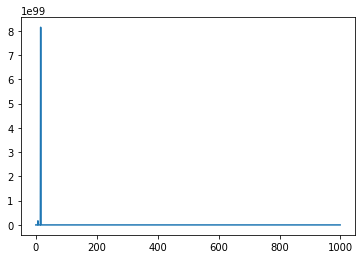

3.449393959777055e+74
4.143196890403187e+87
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 1., 1.]], dtype=torch.float64)
tensor([[ 1.0000e+00,  1.3808e-74,  1.0000e+00,  ...,  1.9359e-06,
          1.0000e+00,  1.0000e+00],
        [ 1.3808e-74,  1.0000e+00,  4.8798e-81,  ...,  1.0000e+00,
          9.3025e-01,  3.4429e-48],
        [ 1.0000e+00,  4.8798e-81,  1.0000e+00,  ...,  1.2655e-21,
          1.0000e+00,  0.0000e+00],
        ...,
        [ 1.9359e-06,  1.0000e+00,  1.2655e-21,  ...,  9.9766e-01,
          8.1175e-10,  1.0000e+00],
        [ 1.0000e+00,  9.3025e-01,  1.0000e+00,  ...,  8.1175e-10,
          1.0000e+00, 4.7984e-133],
        [ 1.0000e+00,  3.4429e-48,  0.0000e+00,  ...,  1.0000e+00,
         4.7984e-133,  1.0000e+00]], dtype=torch.float64)


In [12]:
plt.plot(loss_history)
plt.show()
print(loss_history[0])
print(loss_history[len(loss_history) -1])
print(L, A_hat.data, sep='\n')

## GCN vs VGAE

In [13]:
def test(model, A):
    model.eval()
    _, pred = model(data.x.double(), A).max(dim=1)
    correct = float (pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / data.test_mask.sum().item()
    print('Accuracy: {:.4f}'.format(acc))

In [14]:
class GCN(Module):
    def __init__(self, nfeat, nhid, nclass):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolutionLayer(nfeat, nhid)
        self.gc2 = GraphConvolutionLayer(nhid, nclass)

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

In [15]:
VGAE_A = A_hat.data.clone()
VGAE_A = (VGAE_A > 0.5).float()

In [16]:
gcn1 = GCN(1433, 50, 7)
gcn2 = GCN(1433, 50, 7)
optimizer_gcn_1 = optim.Adam(gcn1.parameters())
optimizer_gcn_2 = optim.Adam(gcn2.parameters())
criterion = nn.CrossEntropyLoss()

### GCN

In [ ]:
del loss_history, loss

import tqdm
loss_history = np.zeros(2500) 

for epoch in tqdm.trange(2500): 
  
    optimizer_gcn_1.zero_grad()
    outputs = gcn1(data.x, L) # Usiamo tutto il dataset
    loss = criterion(outputs[data.train_mask], data.y[data.train_mask]) # Mascheriamo sulla parte di training
    loss.backward()
    optimizer_gcn_1.step()

    loss_history[epoch] = loss.detach().numpy()

In [ ]:
plt.plot(loss_history)
plt.show()

In [ ]:
print(loss_history[len(loss_history) -1])
test(gcn1, L)

### VGAE

In [17]:
del loss_history, loss

import tqdm
loss_history = np.zeros(1000) 

for epoch in tqdm.trange(1000): 
  
    optimizer_gcn_2.zero_grad()
    outputs = gcn2(data.x.double(), VGAE_A.double()) # Usiamo tutto il dataset
    loss = criterion(outputs[data.train_mask], data.y[data.train_mask]) # Mascheriamo sulla parte di training
    loss.backward()
    optimizer_gcn_2.step()

    loss_history[epoch] = loss.detach().numpy()

100%|██████████| 1000/1000 [01:19<00:00, 12.52it/s]


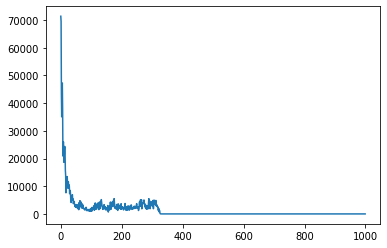

In [18]:
plt.plot(loss_history)
plt.show()

In [19]:
print(loss_history[len(loss_history) -1])
test(gcn2, VGAE_A.double())

1.9459101490553155
Accuracy: 0.0640
